# Dyna-Q: Maze (exemplo 8.1 Sutton&Barto)

Vamos implementar o algoritmo Dyna-Q para resolver o problema descrito no exemplo 8.1 do livro "Reinforcement Learning: An Introduction" de Sutton R. e Barto, A.

O seguinte código foi adaptado de Shangtong Zhang e Kenta Shimada, repositório em:

https://github.com/ShangtongZhang/reinforcement-learning-an-introduction

O problema de a ser resolvido consiste no posicionamento de um agente em um ambiente do tipo GridWorld ilustrado abaixo, onde o agente inicia um episódio na posição indicada por S e o episódio termina quando o mesmo alcança a posição G. O movimento ocorre de forma determinística em função das quatro possíveis ações (N,S,E,W) e as células hachuradas indicam obstáculos sobre os quais o agente não pode se mover.

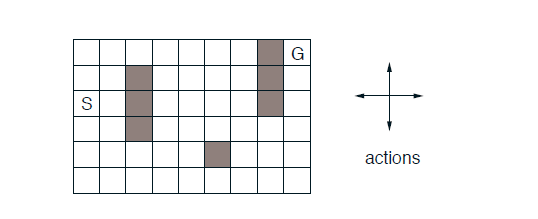

## Imports

In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
matplotlib.use('Agg')
matplotlib.style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from tqdm import tqdm
import heapq
from copy import deepcopy

## Environment Class: Maze

Vamos implementar a classe do ambiente Maze com a dinâmica de transição de estados e função de recompensa associadas ao problema.

In [2]:
# A wrapper class for a maze, containing all the information about the maze.
# Basically it's initialized to DynaMaze by default, however it can be easily adapted
# to other maze
class Maze:
    def __init__(self):
        # maze width
        self.WORLD_WIDTH = 9

        # maze height
        self.WORLD_HEIGHT = 6

        # all possible actions
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.actions = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]

        # start state
        self.START_STATE = [2, 0]

        # goal state
        self.GOAL_STATES = [[0, 8]]

        # all obstacles
        self.obstacles = [[1, 2], [2, 2], [3, 2], [0, 7], [1, 7], [2, 7], [4, 5]]
        self.old_obstacles = None
        self.new_obstacles = None

        # time to change obstacles
        self.obstacle_switch_time = None

        # initial state action pair values
        # self.stateActionValues = np.zeros((self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions)))

        # the size of q value
        self.q_size = (self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions))

        # max steps
        self.max_steps = float('inf')

        # track the resolution for this maze
        self.resolution = 1

    # extend a state to a higher resolution maze
    # @state: state in lower resolution maze
    # @factor: extension factor, one state will become factor^2 states after extension
    def extend_state(self, state, factor):
        new_state = [state[0] * factor, state[1] * factor]
        new_states = []
        for i in range(0, factor):
            for j in range(0, factor):
                new_states.append([new_state[0] + i, new_state[1] + j])
        return new_states

    # extend a state into higher resolution
    # one state in original maze will become @factor^2 states in @return new maze
    def extend_maze(self, factor):
        new_maze = Maze()
        new_maze.WORLD_WIDTH = self.WORLD_WIDTH * factor
        new_maze.WORLD_HEIGHT = self.WORLD_HEIGHT * factor
        new_maze.START_STATE = [self.START_STATE[0] * factor, self.START_STATE[1] * factor]
        new_maze.GOAL_STATES = self.extend_state(self.GOAL_STATES[0], factor)
        new_maze.obstacles = []
        for state in self.obstacles:
            new_maze.obstacles.extend(self.extend_state(state, factor))
        new_maze.q_size = (new_maze.WORLD_HEIGHT, new_maze.WORLD_WIDTH, len(new_maze.actions))
        # new_maze.stateActionValues = np.zeros((new_maze.WORLD_HEIGHT, new_maze.WORLD_WIDTH, len(new_maze.actions)))
        new_maze.resolution = factor
        return new_maze

    # take @action in @state
    # @return: [new state, reward]
    def step(self, state, action):
        x, y = state
        if action == self.ACTION_UP:
            x = max(x - 1, 0)
        elif action == self.ACTION_DOWN:
            x = min(x + 1, self.WORLD_HEIGHT - 1)
        elif action == self.ACTION_LEFT:
            y = max(y - 1, 0)
        elif action == self.ACTION_RIGHT:
            y = min(y + 1, self.WORLD_WIDTH - 1)
        if [x, y] in self.obstacles:
            x, y = state
        if [x, y] in self.GOAL_STATES:
            reward = 1.0
        else:
            reward = 0.0
        return [x, y], reward

## Classe DynaParams

Classe auxiliar para armazenamento de parâmetros do algoritmo Dyna-Q

In [3]:
# a wrapper class for parameters of dyna algorithms
class DynaParams:
    def __init__(self):
        # discount
        self.gamma = 0.95

        # probability for exploration
        self.epsilon = 0.1

        # step size
        self.alpha = 0.1

        # weight for elapsed time
        self.time_weight = 0

        # n-step planning
        self.planning_steps = 5

        # average over several independent runs
        self.runs = 10

        # algorithm names
        self.methods = ['Dyna-Q', 'Dyna-Q+']

        # threshold for priority queue
        self.theta = 0


## Política $\epsilon$-greedy 

A função choose_action(state,q_value,maze,dyna_params) escolhe a ação a ser tomada pelo agente de acordo com a função valor atual e a política $\epsilon$-greedy.

In [4]:
# choose an action based on epsilon-greedy algorithm
def choose_action(state, q_value, maze, dyna_params):
    if np.random.binomial(1, dyna_params.epsilon) == 1:
        return np.random.choice(maze.actions)
    else:
        values = q_value[state[0], state[1], :]
        return np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])



## Classe TrivialModel

A classe TrivialModel representa o modelo $M_\eta$ tabular aprendido pelo agente por meio de interações com ambiente real e utilizado para gerar experiência simulada para planejamento.

In [5]:
# Trivial model for planning in Dyna-Q
class TrivialModel:
    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, rand=np.random):
        self.model = dict()
        self.rand = rand

    # feed the model with previous experience
    def feed(self, state, action, next_state, reward):
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
        self.model[tuple(state)][action] = [list(next_state), reward]

    # randomly sample from previous experience
    def sample(self):
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]
        next_state, reward = self.model[state][action]
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        return list(state), action, list(next_state), reward




## Dyna-Q

Vamos implementar o Algoritmo Dyna-Q que implementa Q-Learning tabular na arquitetura de Model-Based RL Dyna.

A função dyna_q(q_value, model, maze, dyna_params) executa um episódio de interação com o ambiente real, utilizando essa experiência para aprender o modelo tabular $M_\eta$ e depois amostra **$n = $ dyna_params.planning_steps** transições simuladas pelo modelo para treino da Função Valor Q(s,a).

In [6]:
# play for an episode for Dyna-Q algorithm
# @q_value: state action pair values, will be updated
# @model: model instance for planning
# @maze: a maze instance containing all information about the environment
# @dyna_params: several params for the algorithm
def dyna_q(q_value, model, maze, dyna_params):
    state = maze.START_STATE
    steps = 0
    while state not in maze.GOAL_STATES:
        # track the steps
        steps += 1

        # get action
        action = choose_action(state, q_value, maze, dyna_params)
        

        # take action
        next_state, reward = maze.step(state, action)
        

        # Q-Learning update
        q_value[state[0], state[1], action] += \
            dyna_params.alpha * (reward + dyna_params.gamma * np.max(q_value[next_state[0], next_state[1], :]) -
                                 q_value[state[0], state[1], action])
        

        # feed the model with experience
        #-------------------------
        model.feed(state, action, next_state, reward)
        #-------------------------

        # sample experience from the model
        for t in range(0, dyna_params.planning_steps):
            state_, action_, next_state_, reward_ = model.sample()
            q_value[state_[0], state_[1], action_] += \
                dyna_params.alpha * (reward_ + dyna_params.gamma * np.max(q_value[next_state_[0], next_state_[1], :]) -
                                     q_value[state_[0], state_[1], action_])

        state = next_state

        # check whether it has exceeded the step limit
        if steps > maze.max_steps:
            break

    return steps




## Figura 8.2

A funçaõ abaixo implementa o Dyna-Q com diferentes valores para o número de passos de planejamento n=[0, 5, 50] e plota um gráfico com o número de passos de cada episódio real de interação do agente até resolução do MDP.

In [7]:
# Figure 8.2, DynaMaze, use 10 runs instead of 30 runs
def figure_8_2():
    # set up an instance for DynaMaze
    dyna_maze = Maze()
    dyna_params = DynaParams()

    runs = 10
    episodes = 30
    planning_steps = [0, 5, 50]
    steps = np.zeros((len(planning_steps), episodes))

    for run in tqdm(range(runs)):
        for i, planning_step in enumerate(planning_steps):
            dyna_params.planning_steps = planning_step
            q_value = np.zeros(dyna_maze.q_size)

            # generate an instance of Dyna-Q model
            model = TrivialModel()
            for ep in range(episodes):
                # print('run:', run, 'planning step:', planning_step, 'episode:', ep)
                steps[i, ep] += dyna_q(q_value, model, dyna_maze, dyna_params)

    # averaging over runs
    steps /= runs

    fig = plt.figure()
    ax = fig.gca()
    for i in range(len(planning_steps)):
        ax.plot(steps[i, :], label='%d planning steps' % (planning_steps[i]))
    ax.set_xlabel('episodes')
    ax.set_ylabel('steps per episode')
    plt.legend()
    plt.show()

100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


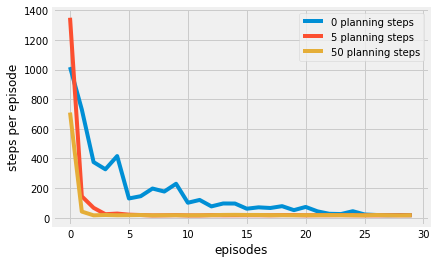

In [8]:
figure_8_2()